# DS in LS Week 5
## SEIRD Model for modelling COVID-19

In [2]:
# Imports
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import pandas as pd
import datetime

## 1. Implement a SIR model to simulate Covid-19 spreading.

In [9]:
# Variables:
N = 50000 # Population size
beta = 2.0  # number of persons an infected person infects each day
D = 7.0 # duration of the infection in days
gamma = 1.0 / D # the proportion of infected recovering per day

S0, I0, R0 = N-1, 1, 0  # initial conditions for S, I and R

In [3]:
# ODE system
def deriv_SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [10]:
t = np.linspace(0, 49, 50) # Grid of time points (in days)
y0 = S0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_SIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [7]:
# a function to plot 
def plotsir(t, S, I, R):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

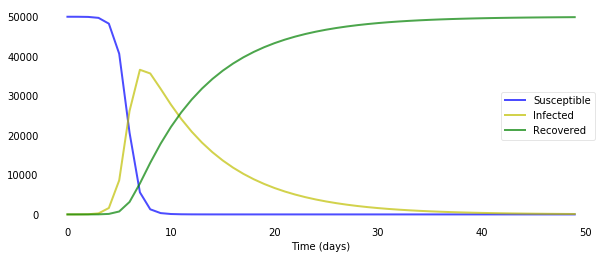

In [11]:
plotsir(t, S, I, R)

## 2. Extend your model, as described in the project proposal:

### 2.1 Add a fourth category of the population for exposed (but not yet infectious) people. Thus people become susceptible, exposed, infected, and finally recovered. 
### 2.2 Add a new parameter for the incubation period. 

In [12]:
def deriv_SEIR(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [15]:
# new initial conditions
N = 50000 # Population size
beta = 2.0  # number of persons an infected person infects each day
D = 7.0 # duration of the infection in days
gamma = 1.0 / D # the proportion of infected recovering per day
delta = 1.0 / 3.0  # 1 devided by the incubation period in days

S0, E0, I0, R0 = N-1, 1, 0, 0  # initial conditions for S, E, I, R

In [16]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_SEIR, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

In [21]:
# a function to plot 
def plotseir(t, S, E, I, R):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

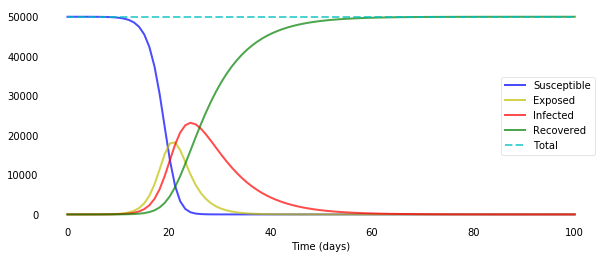

In [22]:
plotseir(t, S, E, I, R)

### 2.3 Add a category for those who die, rather than recover, from COVID-19. And again, a new parameter for the likelihood of death or recovery. This would not be constant (but changes over time).
### 2.4 Take more factors into account: at least population age proportions and two more (e.g. preexisting medical conditions).

In [136]:
def deriv_SEIRD(y, t, N, beta, gamma, delta, alpha_opt_1, alpha_opt_2, rho):
    S, E, I, R, D = y
    def alpha_t(t):
        # the death rate as a time dependent function, with factor age, ressources, previous conditions
        return (a_0_start-a_0_end) / (1 + np.exp(-k*(-t+x0))) + a_0_end + s * I/N + alpha_opt_1 + alpha_opt_2

    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha_t(t)) * gamma * I - alpha_t(t) * rho * I
    dRdt = (1 - alpha_t(t)) * gamma * I
    dDdt = alpha_t(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [135]:
N = 1_000_000 # Population size
D = 7.0 # duration of the infection in days
gamma = 1.0 / D # the proportion of infected recovering per day
delta = 1.0 / 5.0  # 1 devided by the incubation period in days
R_0 = 5.0 # the total number of people an infected person infects
beta = R_0 * gamma  # expected amount of people an infected person infects per day
rho = 1/9  # 1 / the number of days from infection to death

alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.1, "89+": 0.2}
proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
alpha_by_condition = {"nothing": 0.01, "general": 0.05, "pulmonary": 0.2}
proportion_of_condition = {"nothing": 0.7, "general": 0.25, "pulmonary": 0.05}
s = 0.01
alpha_opt_1 = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))
alpha_opt_2 = sum(alpha_by_condition[i] * proportion_of_condition[i] for i in list(alpha_by_condition.keys()))
a_0_start, k, x0, a_0_end = 0.8, 0.1, 75, 0.1

S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions for S, E ,I ,R ,D

In [137]:
t = np.linspace(0, 150, 150) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_SEIRD, y0, t, args=(N, beta, gamma, delta, alpha_opt_1, alpha_opt_2, rho))
S, E, I, R, D = ret.T

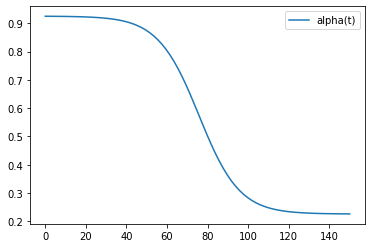

In [138]:
# plot the time dependant death rate
def alpha_t_I(t, I_i):
    # the death rate as a time dependent function, with factor age, ressources, previous conditions
    return (a_0_start-a_0_end) / (1 + np.exp(-k*(-t+x0))) + a_0_end + s * I_i/N + alpha_opt_1 + alpha_opt_2
a0_over_time = [alpha_t_I(i, I[i]) for i in range(len(t))]
plt.plot(t, a0_over_time, label="alpha(t)")
plt.legend()

In [139]:
def plotseird(t, S, E, I, R, D):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
  ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

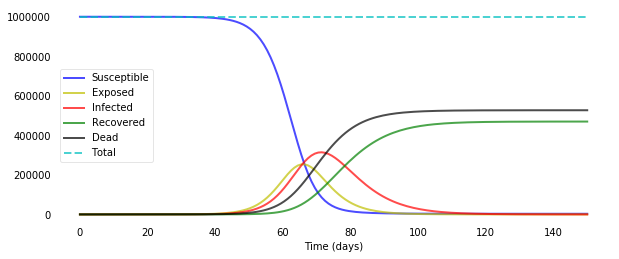

In [140]:
plotseird(t, S, E, I, R, D)

### 2.5 Consider the availability of hospital beds or ventilators which has an impact on the death rate. 
### 2.6 Make as many parameters time-dependent as possible, since it’s likely that parameters such as infection rates would fluctuate. 

### Revised SEICRD model 

In [3]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, alpha_t, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * alpha_t(t) * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - alpha_t(t)) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - alpha_t(t)) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * alpha_t(t) * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [4]:
# parameters
# set the total population number
# from here: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/zensus-geschlecht-staatsangehoerigkeit-2019.html;jsessionid=B6506D714A8218B0616748EA21EBBFB1.internet8721
N = 83149300
# use the culumlative death counts as data input
days = 200
# for the agegroups take demographics percentages from 2018 data and apply to N
# from here: https://de.statista.com/statistik/daten/studie/1351/umfrage/altersstruktur-der-bevoelkerung-deutschlands/
# 0-14, 14-34, 35-59, 60-79, 80+
total_2018 = 83019000.0
age_percentages_2018 = [11290815/total_2018, 19213113/total_2018, 29137839/total_2018, 
                        17988340/total_2018, 5389106/total_2018]
agegroups = [N * x for x in age_percentages_2018] 
deaths_per_agegroup = [1, 16, 351, 2595, 5210]
total_deaths = sum(deaths_per_agegroup)
alpha_by_agegroup = {"0-14": deaths_per_agegroup[0]/total_deaths, "15-34": deaths_per_agegroup[1]/total_deaths, 
                     "35-59": deaths_per_agegroup[2]/total_deaths, "60-79": deaths_per_agegroup[3]/total_deaths, "80+": deaths_per_agegroup[4]/total_deaths}
proportion_of_agegroup = {"0-14": age_percentages_2018[0], "15-34": age_percentages_2018[1], 
                          "35-59": age_percentages_2018[2], "60-79": age_percentages_2018[3], "80+": age_percentages_2018[4]}

# for the prevoius conditions take the death rate by previous condition 
# from here: https://de.statista.com/statistik/daten/studie/1102109/umfrage/mortalitaetsrate-des-coronavirus-nach-vorerkrankung/
alpha_by_condition = {"nothing": 0.0, "other": 0.08, "pulmonary": 0.13}
proportion_of_condition = {"nothing": 0.3, "other": 0.6, "pulmonary": 0.1}

# from here: https://www.tagesspiegel.de/wissen/grosse-datenanalyse-zu-krankenhaeusern-hier-koennten-die-intensivbetten-in-deutschland-knapp-werden/25746240.html
total_beds = 33500
beds_per_100k = total_beds * 100000 / N

# add a factor to the deathrate depending on demographics and previous conditions
alpha_opt_1 = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))
alpha_opt_2 = sum(alpha_by_condition[i] * proportion_of_condition[i] for i in list(alpha_by_condition.keys()))

# set parameters 
R_0_start = 3.0
k = 0.5
x0 = 90
R_0_end = 0.9
prob_I_to_C = 0.1
alpha_start = 0.6
alpha_change = -0.001
s = 0.003
s1 = 0.8
s2 = 0.8

In [5]:
gamma = 1.0/9.0 # the proportion of infected recovering per day
sigma = 1.0/5.0 # 1 devided by the incubation period in days

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, alpha_start, alpha_change, prob_I_to_C, s, s1, s2):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    
    # the death rate as a time dependent function, with factor age, previous conditions and decline over time through better treatment availability
    def alpha_t(t):
        return (max(0.0, (alpha_start + t * alpha_change + s1 * alpha_opt_1 + s2 * alpha_opt_2) ))

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, alpha_t, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    alpha_t_over_time = [alpha_t(i) for i in t]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time

In [6]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU, from: {S_2[0] * 100}, to:{S_2[-1] * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')



    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
#         ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
#         ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')



    ax.title.set_text('extended SEIR-Model zoomed')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    print("final numbers: S: {:.0f} E: {:.0f} I: {:.0f} C: {:.0f} R: {:.0f} D: {:.0f}".format(S[-1],E[-1],I[-1],C[-1],R[-1],D[-1]))
    
    f = plt.figure(figsize=(20,8))
    # sp1
    ax1 = f.add_subplot(221)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
    # sp2
    ax4 = f.add_subplot(222)
    if x_ticks is None:
        ax4.plot(t, S_2, 'b--', alpha=0.7, linewidth=2, label='alpha_t')
    else:
        ax4.plot(x_ticks, S_2, 'b--', alpha=0.7, linewidth=2, label='alpha_t')

 
    ax4.title.set_text('alpha_t over time')
    ax4.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax4.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp3
    ax2 = f.add_subplot(223)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp4
    ax3 = f.add_subplot(224)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

Prediction
percentage going to ICU: 10.0; percentage dying in ICU, from: 74.93762953634018, to:55.03762953634017


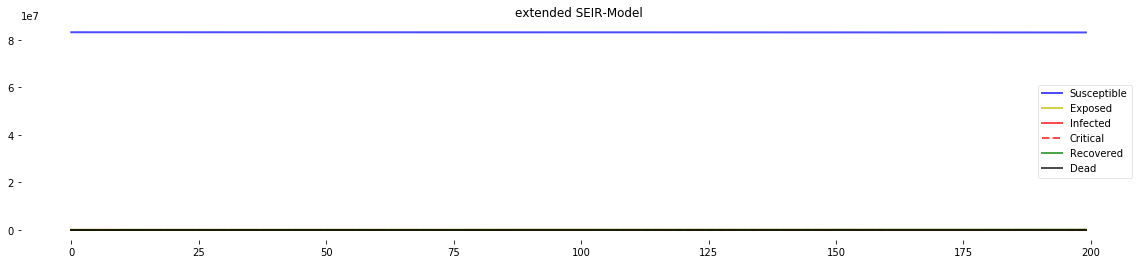

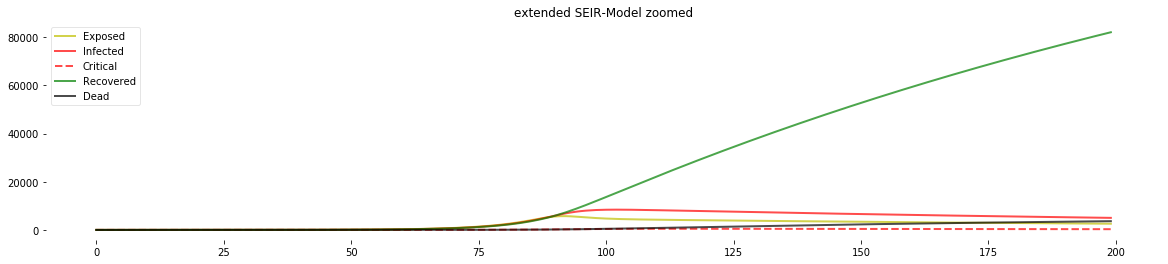

final numbers: S: 83055743 E: 2571 I: 5004 C: 305 R: 82047 D: 3630


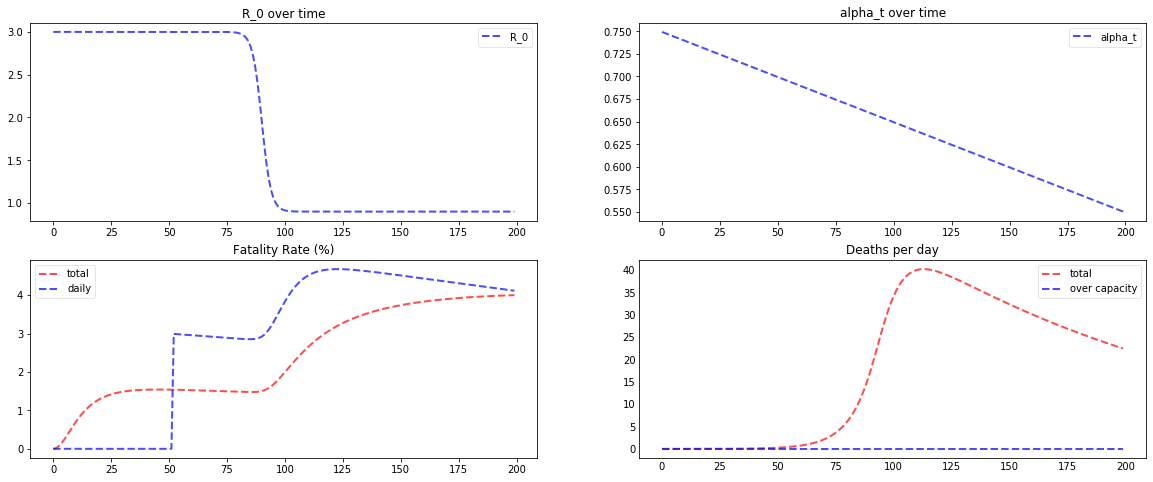

In [7]:
full_days = days
# first_date = datetime.date(2020,3,1)
# x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction")
plotter(*Model(full_days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, alpha_start, alpha_change, prob_I_to_C, s, s1, s2));

## 3. Fit the model to real-world data, either Germany or Berlin.

### Fitting real data

Load in the data from the RKI npgeo dataset

In [9]:
# dataset:
# https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0
# Metadata: https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
rki_covid_data = pd.read_csv("..\\Week 5\\RKI_COVID19.csv", header=0, sep=",")
rki_covid_data.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,8389847,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
1,8389848,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
2,8389849,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
3,8389850,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
4,8389851,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt


In [10]:
# create a column containing the date
rki_covid_data["Date"] = pd.to_datetime(rki_covid_data['Meldedatum'], format='%Y/%m/%d %H:%M:%S.%f')
rki_covid_data["Date"] = rki_covid_data['Date'].dt.date
rki_covid_data.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,Date
0,8389847,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-14
1,8389848,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-19
2,8389849,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-19
3,8389850,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-21
4,8389851,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt,2020-03-27


In [6]:
rki_covid_data["NeuerTodesfall"].value_counts()

-9    133241
 0      7571
 1        28
-1         1
Name: NeuerTodesfall, dtype: int64

In [11]:
# filter the dataframe for deaths per day by multiplying entries by the number of deaths they count
# deaths_per_day_pre = rki_covid_data[rki_covid_data['NeuerTodesfall'].isin([0,1])].groupby("Date")['AnzahlTodesfall'].value_counts()
# deaths_per_day = pd.DataFrame(index=deaths_per_day_pre.index.get_level_values('Date'))
# deaths_per_day["Deaths"] = 0
# for date in deaths_per_day.index:
#     for level in deaths_per_day_pre.loc[date].index.get_level_values(0):
#         deaths_per_day.at[date, "Deaths"] = deaths_per_day.at[date, "Deaths"] + level * deaths_per_day_pre.loc[date, level]
# deaths_per_day
deaths_per_day = rki_covid_data[rki_covid_data['NeuerFall'].isin([0,1])].groupby("Date", as_index=True).AnzahlTodesfall.sum()
cases_per_day = rki_covid_data[rki_covid_data['NeuerFall'].isin([0,1])].groupby("Date", as_index=True).AnzahlFall.sum()
deaths_per_day
cases_per_day

Date
2020-01-28       4
2020-01-29       2
2020-01-31       3
2020-02-03       1
2020-02-04       5
2020-02-06       1
2020-02-07       1
2020-02-11       2
2020-02-12       2
2020-02-20       1
2020-02-22       1
2020-02-24       2
2020-02-25       2
2020-02-26       7
2020-02-27      23
2020-02-28      48
2020-02-29      22
2020-03-01      38
2020-03-02      41
2020-03-03      83
2020-03-04     158
2020-03-05     190
2020-03-06     188
2020-03-07     139
2020-03-08     101
2020-03-09     344
2020-03-10     593
2020-03-11     747
2020-03-12     983
2020-03-13    1434
              ... 
2020-04-22    2499
2020-04-23    2088
2020-04-24    1892
2020-04-25    1304
2020-04-26     696
2020-04-27    1125
2020-04-28    1453
2020-04-29    1433
2020-04-30    1467
2020-05-01     912
2020-05-02     622
2020-05-03     428
2020-05-04     729
2020-05-05    1098
2020-05-06    1203
2020-05-07    1181
2020-05-08     983
2020-05-09     670
2020-05-10     342
2020-05-11     686
2020-05-12     841
2020-05

In [12]:
# drop all dates before 2020/3/1
data_pre = deaths_per_day[datetime.date(2020,3,1):]
# data_pre = cases_per_day[datetime.date(2020,3,1):]
data_pre

Date
2020-03-01      0
2020-03-02      0
2020-03-03      0
2020-03-04      2
2020-03-05      1
2020-03-06      4
2020-03-07      4
2020-03-08      0
2020-03-09      6
2020-03-10      4
2020-03-11      7
2020-03-12     11
2020-03-13     15
2020-03-14     20
2020-03-15     13
2020-03-16     35
2020-03-17     40
2020-03-18     63
2020-03-19     61
2020-03-20     95
2020-03-21     92
2020-03-22     74
2020-03-23    123
2020-03-24    162
2020-03-25    211
2020-03-26    258
2020-03-27    253
2020-03-28    238
2020-03-29    160
2020-03-30    256
             ... 
2020-04-22    119
2020-04-23     99
2020-04-24     75
2020-04-25     66
2020-04-26     25
2020-04-27     68
2020-04-28     65
2020-04-29     45
2020-04-30     58
2020-05-01     40
2020-05-02     26
2020-05-03     12
2020-05-04     30
2020-05-05     36
2020-05-06     25
2020-05-07     28
2020-05-08     21
2020-05-09     12
2020-05-10      6
2020-05-11     17
2020-05-12     16
2020-05-13     14
2020-05-14      5
2020-05-15      7
2020-

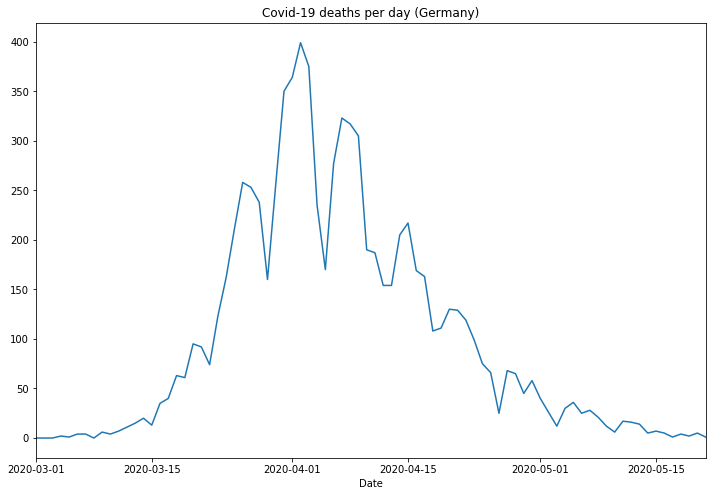

In [13]:
data_pre.plot(figsize=(12, 8), title="Covid-19 deaths per day (Germany)")

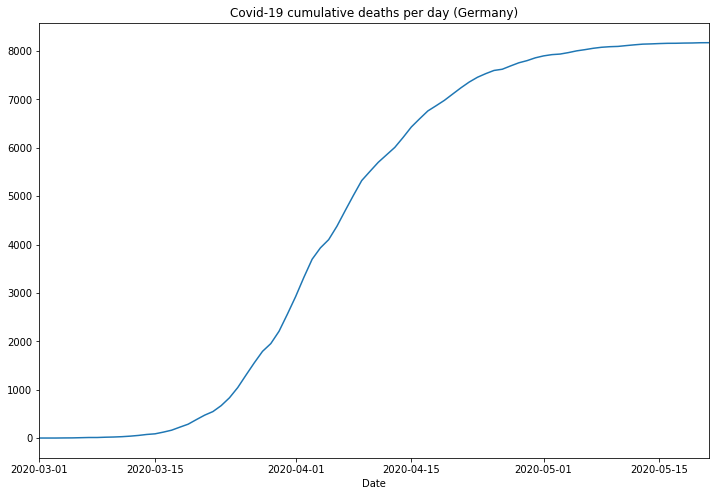

In [14]:
data_pre.cumsum().plot(figsize=(12, 8), title="Covid-19 cumulative deaths per day (Germany)")

In [15]:
rki_covid_data["Altersgruppe"].unique()

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A05-A14', 'A00-A04',
       'unbekannt'], dtype=object)

In [16]:
# calculate the deaths per agegroup
rki_reduced = rki_covid_data[rki_covid_data['NeuerFall'].isin([0,1])]
deaths_per_agegroup = [0, 0, 0, 0, 0]
for i in range(-1, rki_reduced["AnzahlTodesfall"].max()+1):
    deaths_per_agegroup[0] = deaths_per_agegroup[0] + i * len(rki_reduced[((rki_reduced["Altersgruppe"] == "A00-A04") |  (rki_reduced["Altersgruppe"] == "A05-A14")) & (rki_reduced["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[1] = deaths_per_agegroup[1] + i * len(rki_reduced[(rki_reduced["Altersgruppe"] == "A15-A34") & (rki_reduced["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[2] = deaths_per_agegroup[2] + i * len(rki_reduced[(rki_reduced["Altersgruppe"] == "A35-A59") & (rki_reduced["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[3] = deaths_per_agegroup[3] + i * len(rki_reduced[(rki_reduced["Altersgruppe"] == "A60-A79") & (rki_reduced["AnzahlTodesfall"] == i)])
    deaths_per_agegroup[4] = deaths_per_agegroup[4] + i * len(rki_reduced[(rki_reduced["Altersgruppe"] == "A80+") & (rki_reduced["AnzahlTodesfall"] == i)])
print(deaths_per_agegroup)
print(sum(deaths_per_agegroup))

[1, 16, 351, 2595, 5210]
8173


In [17]:
# use the culumlative death counts as data input
data_pre.cumsum().values

array([   0,    0,    0,    2,    3,    7,   11,   11,   17,   21,   28,
         39,   54,   74,   87,  122,  162,  225,  286,  381,  473,  547,
        670,  832, 1043, 1301, 1554, 1792, 1952, 2208, 2558, 2922, 3321,
       3696, 3931, 4101, 4378, 4701, 5018, 5323, 5513, 5700, 5854, 6008,
       6213, 6430, 6599, 6762, 6870, 6981, 7111, 7240, 7359, 7458, 7533,
       7599, 7624, 7692, 7757, 7802, 7860, 7900, 7926, 7938, 7968, 8004,
       8029, 8057, 8078, 8090, 8096, 8113, 8129, 8143, 8148, 8155, 8160,
       8161, 8165, 8167, 8172, 8173], dtype=int64)

In [18]:
# parameters
# set the total population number
# from here: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/zensus-geschlecht-staatsangehoerigkeit-2019.html;jsessionid=B6506D714A8218B0616748EA21EBBFB1.internet8721
N = 83149300
# use the culumlative death counts as data input
data = data_pre.cumsum().values
days = len(data)
# for the agegroups take demographics percentages from 2018 data and apply to N
# from here: https://de.statista.com/statistik/daten/studie/1351/umfrage/altersstruktur-der-bevoelkerung-deutschlands/
# 0-14, 14-34, 35-59, 60-79, 80+
total_2018 = 83019000.0
age_percentages_2018 = [11290815/total_2018, 19213113/total_2018, 29137839/total_2018, 
                        17988340/total_2018, 5389106/total_2018]
agegroups = [N * x for x in age_percentages_2018] 
total_deaths = sum(deaths_per_agegroup)
alpha_by_agegroup = {"0-14": deaths_per_agegroup[0]/total_deaths, "15-34": deaths_per_agegroup[1]/total_deaths, 
                     "35-59": deaths_per_agegroup[2]/total_deaths, "60-79": deaths_per_agegroup[3]/total_deaths, "80+": deaths_per_agegroup[4]/total_deaths}
proportion_of_agegroup = {"0-14": age_percentages_2018[0], "15-34": age_percentages_2018[1], 
                          "35-59": age_percentages_2018[2], "60-79": age_percentages_2018[3], "80+": age_percentages_2018[4]}

# for the prevoius conditions take the death rate by previous condition 
# from here: https://de.statista.com/statistik/daten/studie/1102109/umfrage/mortalitaetsrate-des-coronavirus-nach-vorerkrankung/
alpha_by_condition = {"nothing": 0.0, "other": 0.08, "pulmonary": 0.13}
proportion_of_condition = {"nothing": 0.3, "other": 0.6, "pulmonary": 0.1}

# from here: https://www.tagesspiegel.de/wissen/grosse-datenanalyse-zu-krankenhaeusern-hier-koennten-die-intensivbetten-in-deutschland-knapp-werden/25746240.html
total_beds = 33500
beds_per_100k = total_beds * 100000 / N

# add a factor to the deathrate depending on demographics and previous conditions
alpha_opt_1 = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))
alpha_opt_2 = sum(alpha_by_condition[i] * proportion_of_condition[i] for i in list(alpha_by_condition.keys()))

# set parameters for fitting, form: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (20, 0,50), "R_0_end": (0.9, 0.3, 1.0),
                       "prob_I_to_C": (0.05, 0.01, 0.3), 
                       "a_0_start": (0.5, 0.0, 0.7), "k2": (2.5, 0.01, 5.0), "x2_0": (20, 0, 50), "a_0_end": (0.2, 0.01, 0.7),
                      "s": (0.003, 0.001, 0.01), "s1": (0.3, 0.0, 0.6), "s2": (0.3, 0.0, 0.6)} 

In [19]:
gamma = 1.0/9.0 # the proportion of infected recovering per day
sigma = 1.0/3.0 # 1 devided by the incubation period in days

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    
    # the death rate as a time dependent function, with factor age, previous conditions and decline over time through better treatment availability
    def alpha_t(t):
        return min(1.0,(a_0_start-a_0_end) / (1 + np.exp(-k2*(-t+x2_0))) + a_0_end + s1 * alpha_opt_1 + s2 * alpha_opt_2)
#     def alpha_t(t):
#         return (max(0.0, (alpha_start + t * alpha_change + s1 * alpha_opt_1 + s2 * alpha_opt_2) ))

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, alpha_t, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    alpha_t_over_time = [alpha_t(i) for i in t]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time

In [20]:
def fitter(x, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2)
    return ret[6][x]

In [21]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [22]:
x_data = np.linspace(0, days - 1, days, dtype=int)
result = mod.fit(data, params, method="least_squares", x=x_data)

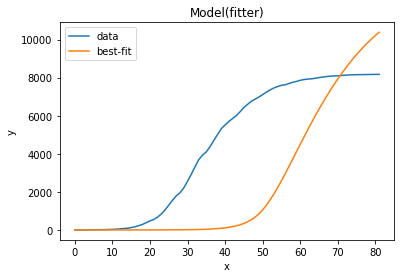

In [23]:
result.plot_fit(datafmt="-");

In [24]:
result.best_values

{'R_0_start': 4.999999999999999,
 'k': 4.999759427677943,
 'x0': 47.90666750021477,
 'R_0_end': 0.30000000000120347,
 'a_0_start': 0.6999999999999785,
 'k2': 4.991740635563017,
 'x2_0': 49.43189942729267,
 'a_0_end': 0.6999999999999998,
 'prob_I_to_C': 0.29999999999999993,
 's': 0.001528411552957964,
 's1': 0.599999999706639,
 's2': 0.5999999851745902}

Prediction for Germany
percentage going to ICU: 29.999999999999993; percentage dying in ICU, from: 81.20322205812984, to:81.20322205813197


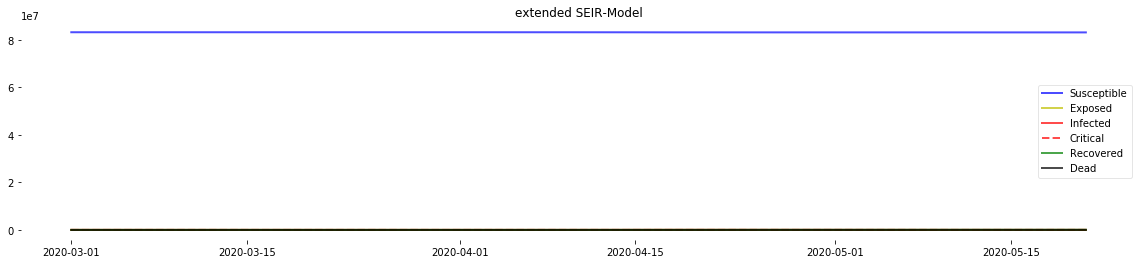

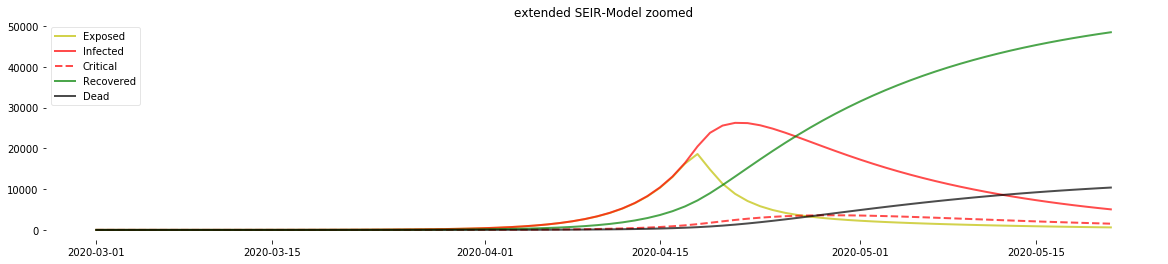

final numbers: S: 83083262 E: 618 I: 5040 C: 1528 R: 48467 D: 10385


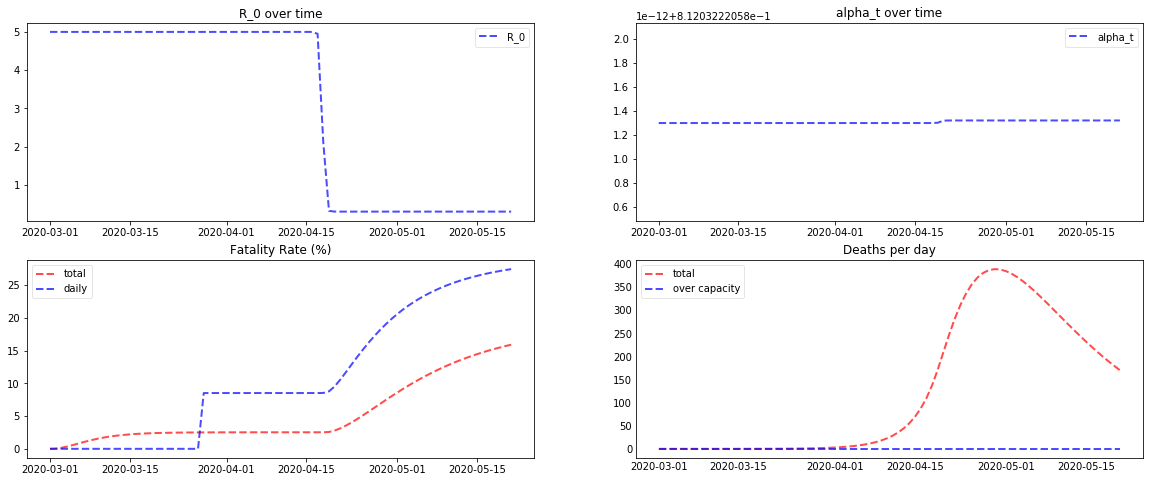

In [25]:
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Germany")
plotter(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

In [31]:
#t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time
for_file = Model(full_days, agegroups, beds_per_100k, **result.best_values)
pd.DataFrame({"S":for_file[1], "E": for_file[2], "I":for_file[3], "C": for_file[4], "R": for_file[5], 
              "D": for_file[6]}, index=x_ticks).to_csv("SEICRD_daily.csv", sep=",")

## 4. Simulate different situations: lock-down, people are reducing social contacts a lot, people are reducing social contacts moderately, people are reducing social contacts moderately and are wearing masks.

### 4.1 lock-down

Prediction lock-down on day 120
percentage going to ICU: 10.0; percentage dying in ICU, from: 79.33601846020869, to:76.74601846019931


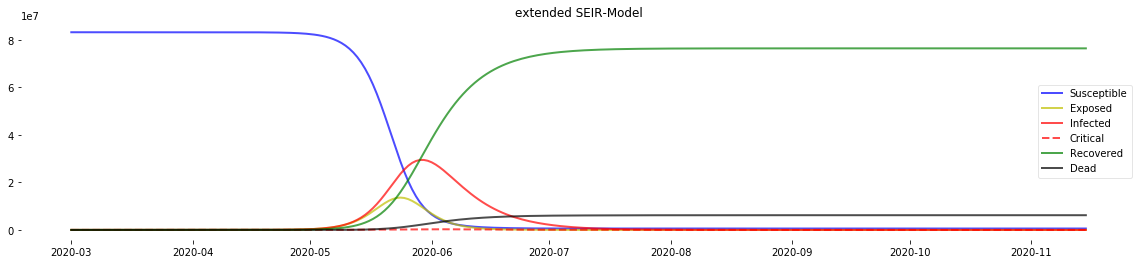

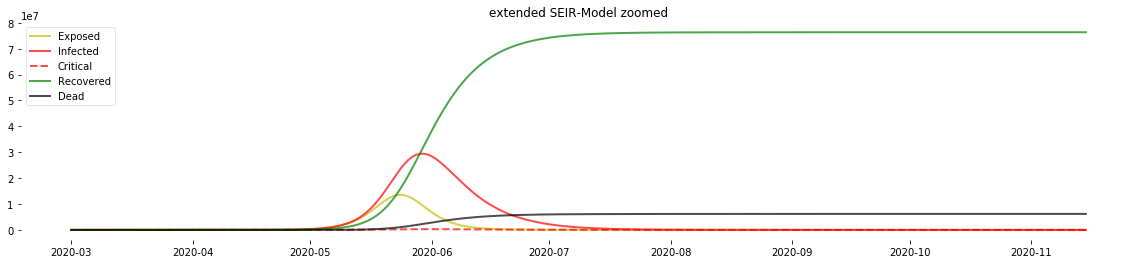

final numbers: S: 590810 E: 0 I: 1 C: 0 R: 76370806 D: 6187683


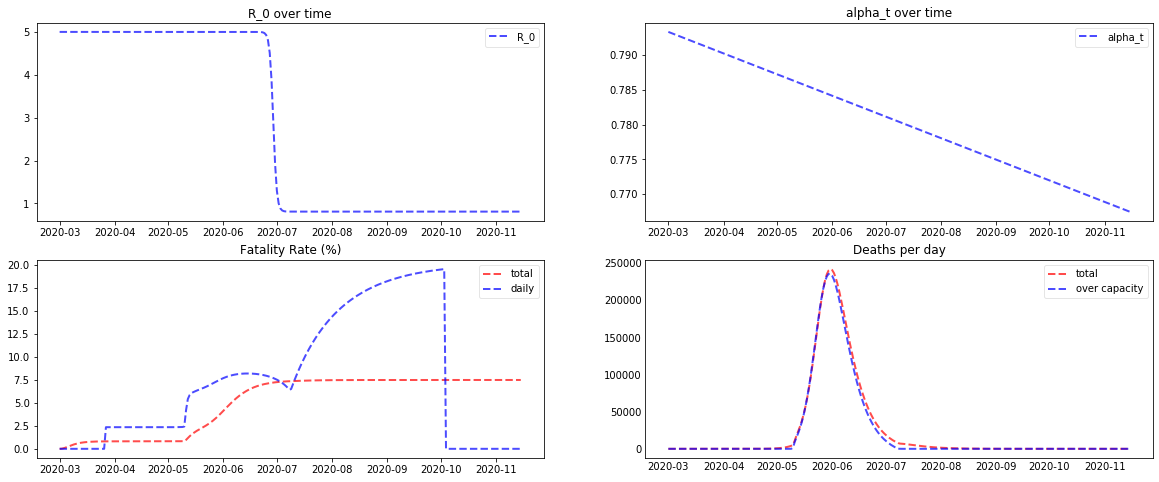

In [300]:
# lockdown only on day 120 onstead of day 63
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
input_vals[2] = 120 #replace the value of x0
print("Prediction lock-down on day 120")
plotter(*Model(full_days, agegroups, beds_per_100k, *input_vals), x_ticks=x_ticks);

Prediction lock-down on day 20
percentage going to ICU: 10.0; percentage dying in ICU, from: 79.33601846020869, to:76.74601846019931


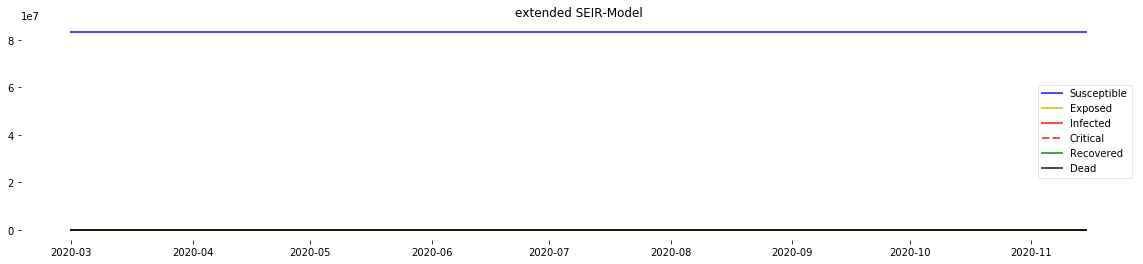

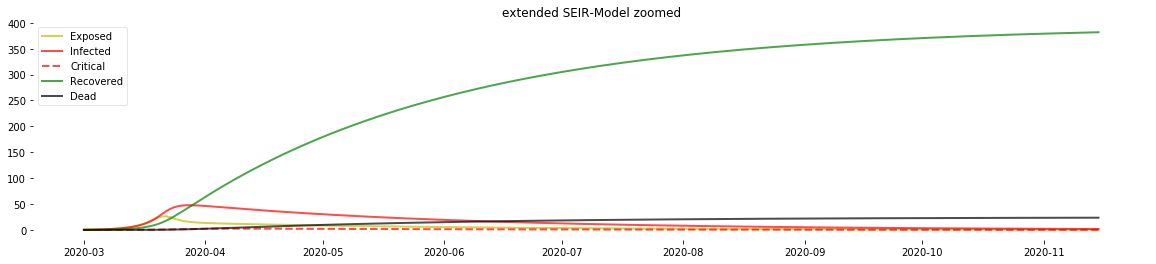

final numbers: S: 83148892 E: 0 I: 2 C: 0 R: 382 D: 24


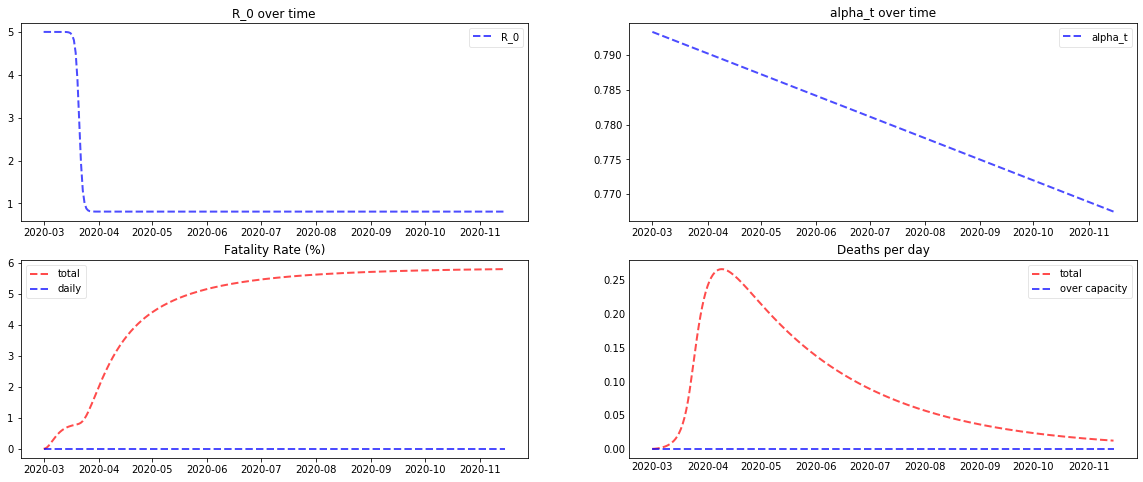

In [301]:
# lockdown on day 20 onstead of day 63
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
input_vals[2] = 20 #replace the value of x0
print("Prediction lock-down on day 20")
plotter(*Model(full_days, agegroups, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.2 people are reducing social contacts a lot

Prediction R_0_end of 0.5
percentage going to ICU: 10.0; percentage dying in ICU, from: 79.33601846020869, to:76.74601846019931


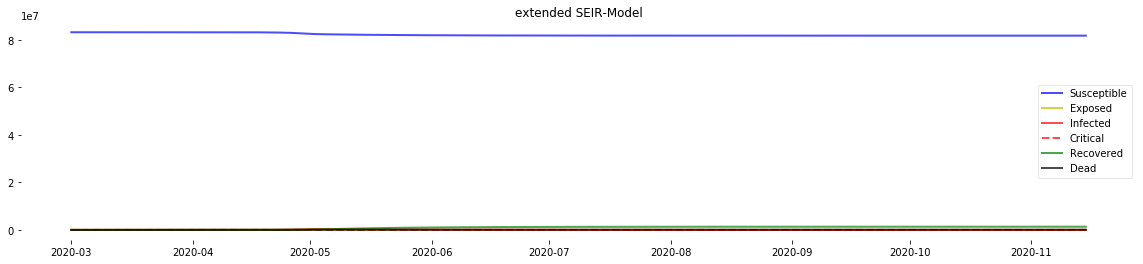

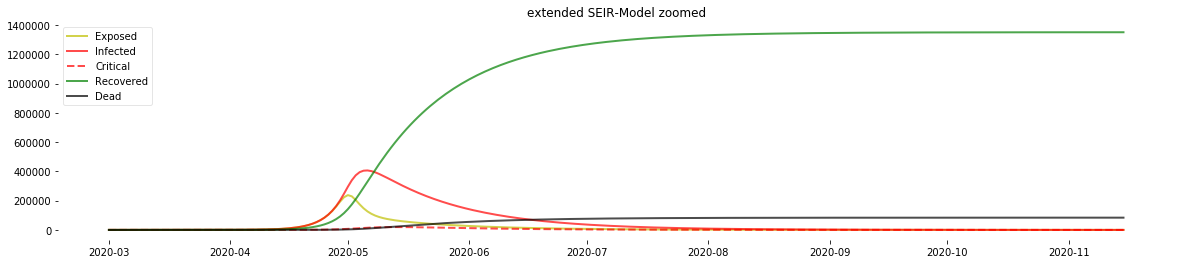

final numbers: S: 81715014 E: 14 I: 75 C: 7 R: 1350426 D: 83764


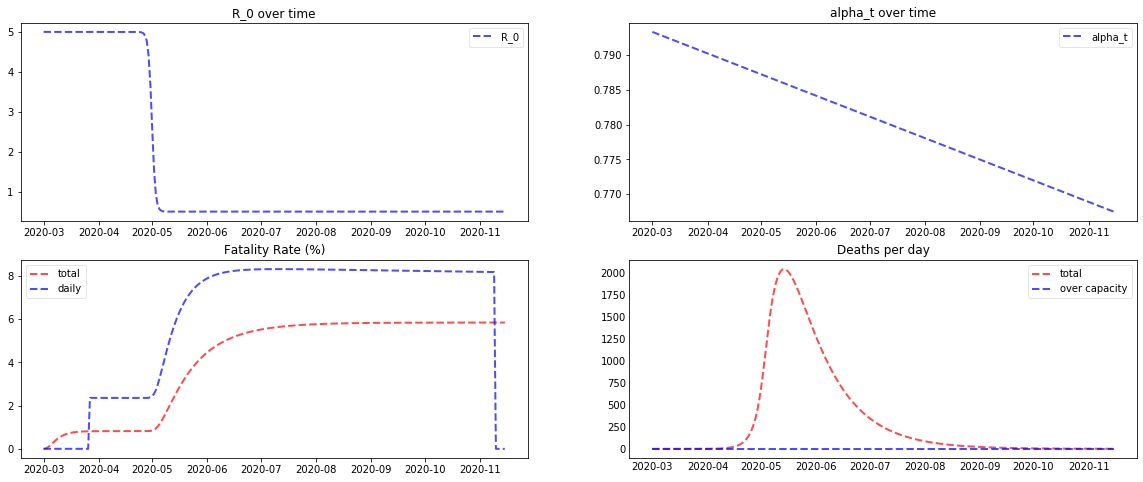

In [302]:
# an infected person can in the end only infect 0.5 other people
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
input_vals[3] = 0.5 #replace the value of R_0_end
print("Prediction R_0_end of 0.5")
plotter(*Model(full_days, agegroups, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.3 people are reducing social contacts moderately

Prediction R_0_end of 2
percentage going to ICU: 10.0; percentage dying in ICU, from: 79.33601846020869, to:76.74601846019931


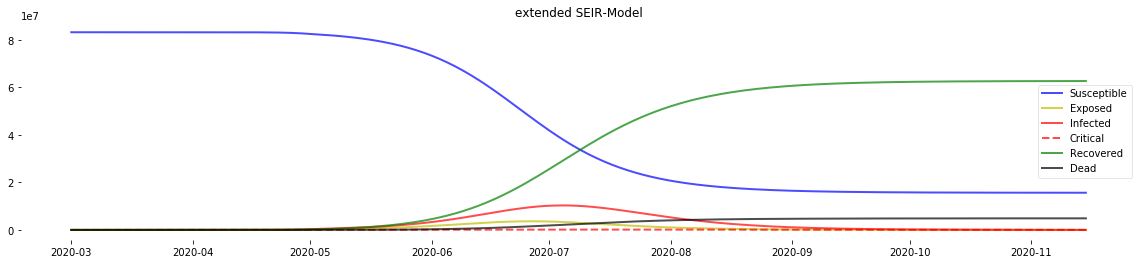

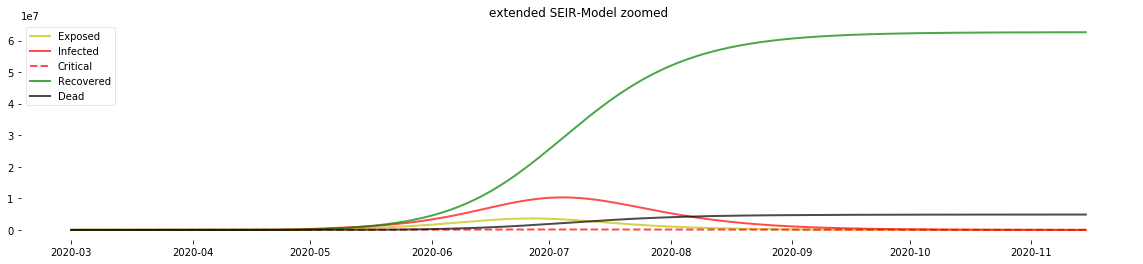

final numbers: S: 15640192 E: 2310 I: 15223 C: 1577 R: 62622003 D: 4867994


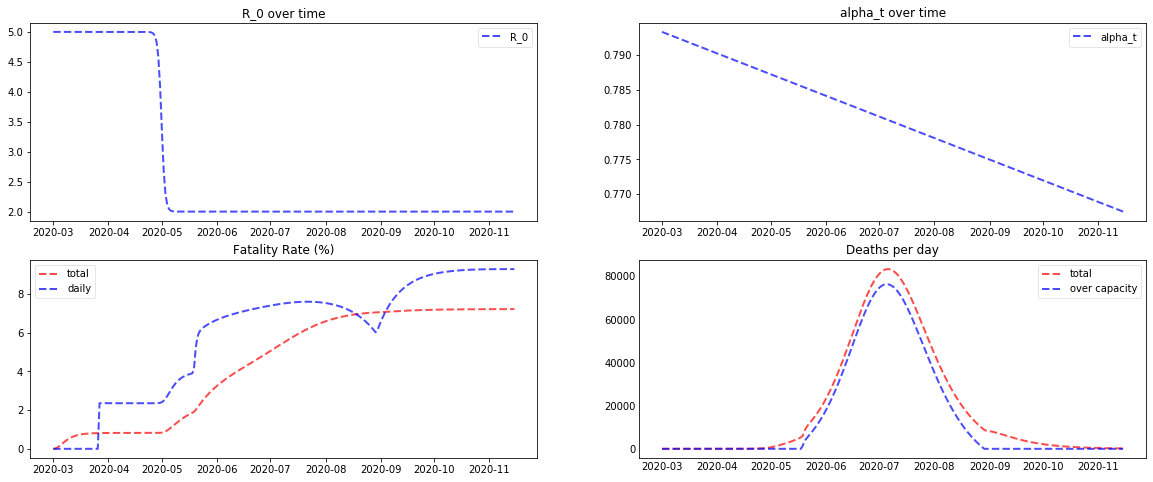

In [303]:
# an infected person can in the end only infect 2 other people
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
input_vals[3] = 2 #replace the value of R_0_end
print("Prediction R_0_end of 2")
plotter(*Model(full_days, agegroups, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.4 people are reducing social contacts moderately and are wearing masks

Prediction R_0_end of 1
percentage going to ICU: 10.0; percentage dying in ICU, from: 79.33601846020869, to:76.74601846019931


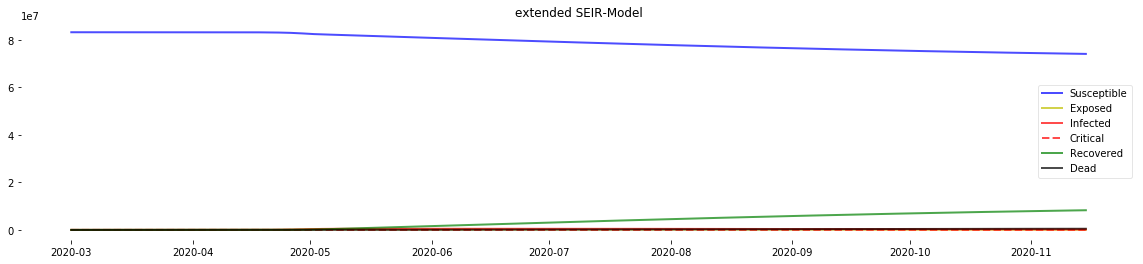

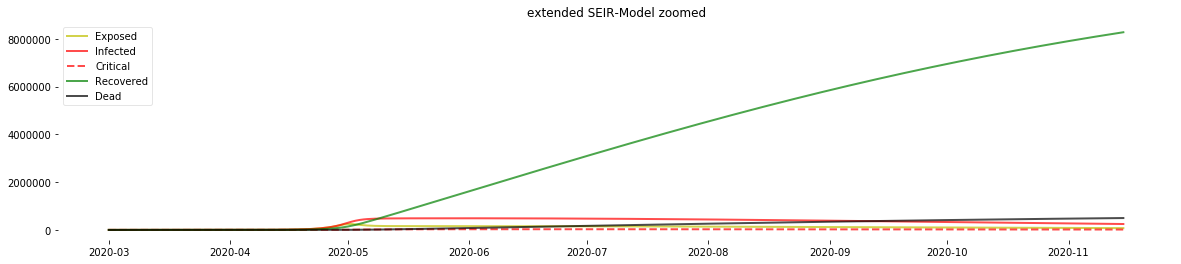

final numbers: S: 74040342 E: 74963 I: 246948 C: 15691 R: 8274613 D: 496743


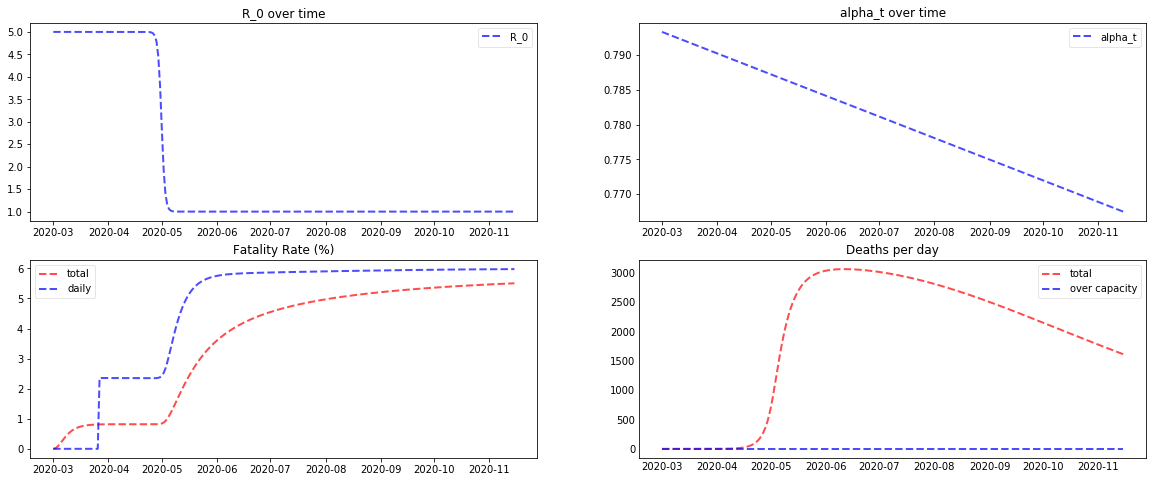

In [304]:
# an infected person can in the end only infect 1 other person
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
input_vals[3] = 1 #replace the value of R_0_end
print("Prediction R_0_end of 1")
plotter(*Model(full_days, agegroups, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.5 a treatment is discovered and reduces the death rate quickly

Prediction alpha_change of -0.01
percentage going to ICU: 10.0; percentage dying in ICU, from: 79.33601846020869, to:0.0


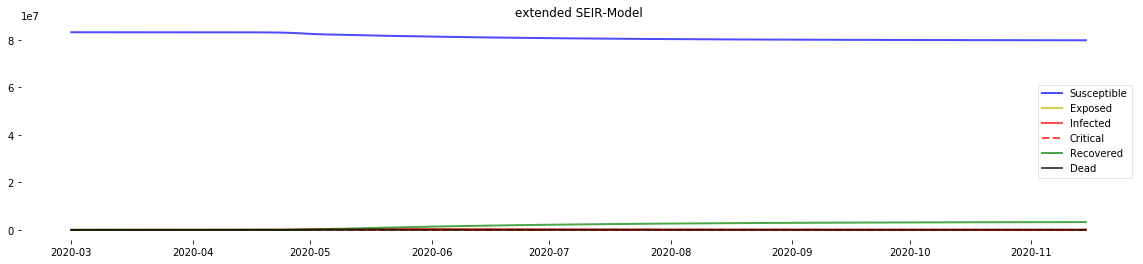

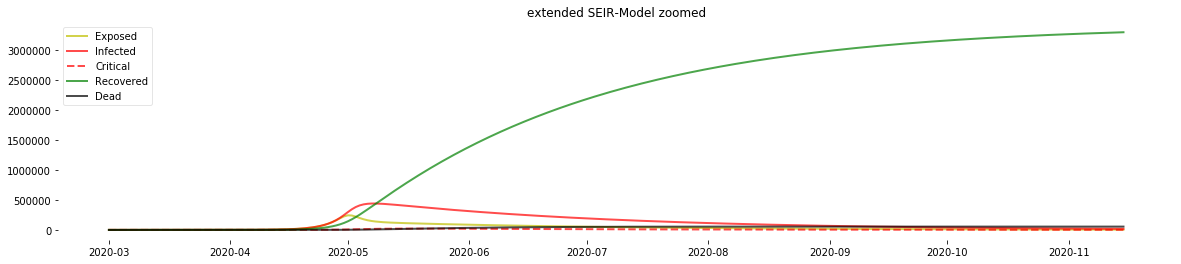

final numbers: S: 79778041 E: 5015 I: 18377 C: 1122 R: 3291626 D: 55118


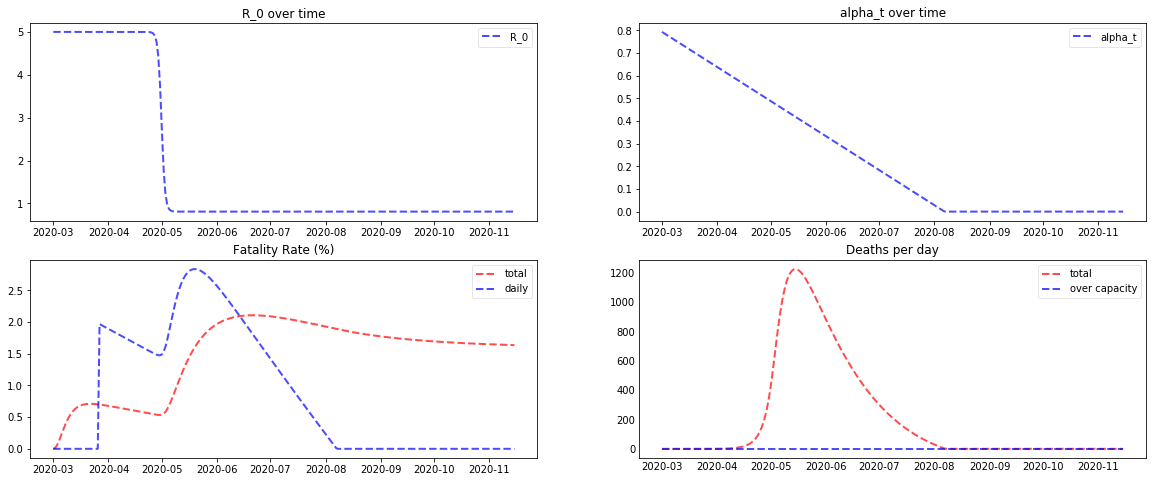

In [308]:
# deathrate drops much faster from -0.001 to -0.005 per day
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
input_vals[5] = -0.005 #replace the value of alpha_change
print("Prediction alpha_change of -0.01")
plotter(*Model(full_days, agegroups, beds_per_100k, *input_vals), x_ticks=x_ticks);

### 4.6 a lot less ICU beds are available

Prediction beds_per_100k // 4
percentage going to ICU: 10.0; percentage dying in ICU, from: 79.33601846020869, to:76.74601846019931


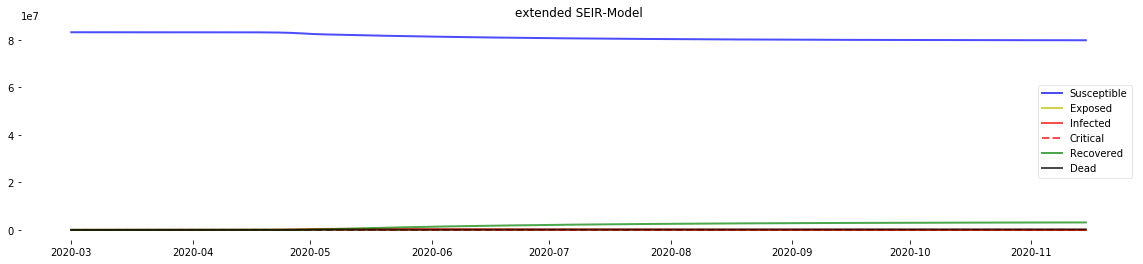

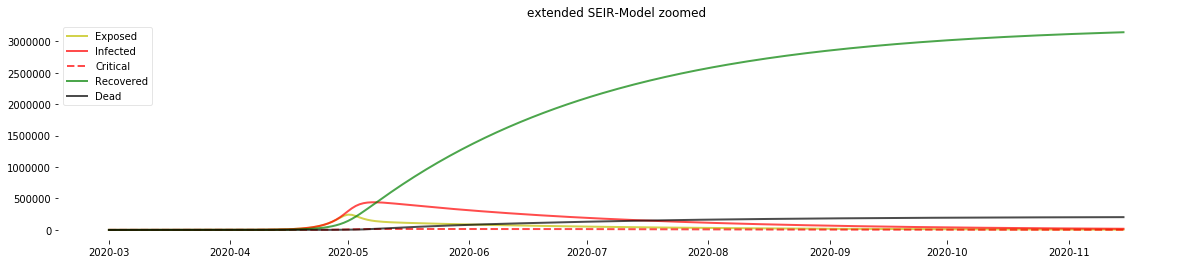

final numbers: S: 79778041 E: 5015 I: 18377 C: 1268 R: 3143518 D: 203080


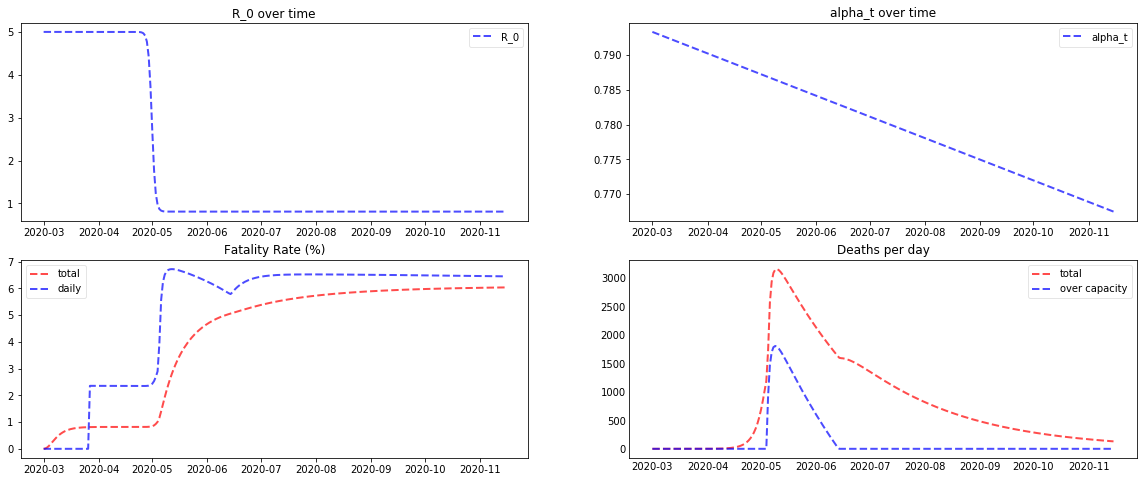

In [312]:
# only a quarter of the number of icu beds are available
full_days = len(data)
first_date = data_pre.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
input_vals = list(result.best_values.values())
print("Prediction beds_per_100k // 4")
plotter(*Model(full_days, agegroups, beds_per_100k // 4, *input_vals), x_ticks=x_ticks);